# Keras CNN with scikeras
This notebook shows a minimal working example of a keras CNN model with sci-keras.

In [39]:
import numpy as np
import idx2numpy
import matplotlib.pyplot as plt
import tensorflow as tf

from math import sqrt
from keras import layers, models
from scikeras.wrappers import KerasClassifier

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import logging
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

## Helper functions
The cnn model and a transformer

In [40]:
# meta = {
#     "n_features_in_": 784,
#     "X_shape_": (60000, 28*28),
#     "n_classes_": 10,
# }

# def mnist_cnn(hidden_layer_dim=100, meta=meta):
#     # note that meta is a special argument that will be
#     # handed a dict containing input metadata
#     n_features_in_ = meta["n_features_in_"]
#     X_shape_ = meta["X_shape_"]
#     n_classes_ = meta["n_classes_"]

#     model = models.Sequential()
#     model.add(layers.Dense(n_features_in_, input_shape=X_shape_[1:]))
#     model.add(layers.Activation("relu"))
#     model.add(layers.Dense(hidden_layer_dim))
#     model.add(layers.Activation("relu"))
#     model.add(layers.Dense(n_classes_))
#     model.add(layers.Activation("softmax"))
#     return model

def mnist_cnn(meta):
    X_shape_ = meta["X_shape_"][1:]
    n_classes_ = meta["n_classes_"]

    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_shape_, padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(n_classes_))
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

class UnFlattenTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        size = int (sqrt(X.shape[1]))
        return X.reshape(-1, size, size, 1)

## Variables
The classifier, pipeline and gridsearch

In [41]:
X = idx2numpy.convert_from_file('mnist_data/train_file_image').reshape(60000, 784)
y = idx2numpy.convert_from_file('mnist_data/train_file_label')
X_test = idx2numpy.convert_from_file('mnist_data/test_file_image').reshape(10000, 784)
y_test = idx2numpy.convert_from_file('mnist_data/test_file_label')

classifier = KerasClassifier(
    mnist_cnn,
    loss="sparse_categorical_crossentropy",
    verbose=0,
    epochs=10,
    random_state=42,
)

pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('pca', PCA(svd_solver="full", random_state=42)),
    ('unflatten', UnFlattenTransformer()),
    ('classifier', classifier),
])

hyperparameters = {
    "pca__n_components": [11*11, 20*20],
    "classifier__optimizer": ["adam", "sgd"],
    "classifier__batch_size": [128, 256],
    "classifier__optimizer__learning_rate": [0.0001, 0.001, 0.1],
}

gridsearch = GridSearchCV(
    pipeline,
    hyperparameters,
    cv=5,
    verbose=2,
    n_jobs=-1)

## Fitting the model
The model is fit on some tutorial data.

In [43]:
gridsearch.fit(X[:500], y[:500])
y_pred = gridsearch.best_estimator_.predict(X_test)
print(gridsearch.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END classifier__batch_size=128, classifier__optimizer=adam, classifier__optimizer__learning_rate=0.0001, pca__n_components=121; total time=   4.0s
[CV] END classifier__batch_size=128, classifier__optimizer=adam, classifier__optimizer__learning_rate=0.001, pca__n_components=121; total time=   4.0s
[CV] END classifier__batch_size=128, classifier__optimizer=adam, classifier__optimizer__learning_rate=0.001, pca__n_components=121; total time=   4.2s
[CV] END classifier__batch_size=128, classifier__optimizer=adam, classifier__optimizer__learning_rate=0.0001, pca__n_components=121; total time=   4.5s
[CV] END classifier__batch_size=128, classifier__optimizer=adam, classifier__optimizer__learning_rate=0.0001, pca__n_components=121; total time=   5.0s
[CV] END classifier__batch_size=128, classifier__optimizer=adam, classifier__optimizer__learning_rate=0.0001, pca__n_components=400; total time=   5.4s
[CV] END classifier__batch_s

              precision    recall  f1-score   support

           0       0.90      0.82      0.86       980
           1       0.93      0.94      0.93      1135
           2       0.54      0.81      0.65      1032
           3       0.79      0.47      0.59      1010
           4       0.69      0.69      0.69       982
           5       0.58      0.60      0.59       892
           6       0.53      0.60      0.56       958
           7       0.82      0.56      0.66      1028
           8       0.70      0.46      0.55       974
           9       0.53      0.77      0.63      1009

    accuracy                           0.68     10000
   macro avg       0.70      0.67      0.67     10000
weighted avg       0.70      0.68      0.68     10000



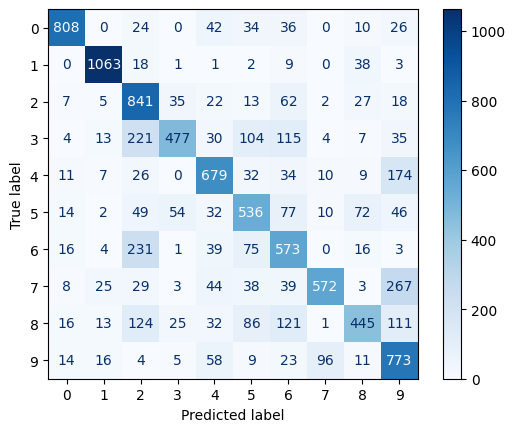

In [ ]:
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(cmap=plt.cm.Blues)